
Chatbot
================



In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import requests
!pip install wikipedia
import wikipedia as wk
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp36-none-any.whl size=11686 sha256=4b9fefdf8718f0dada3278499e0391bdba995b913ea61a85677d034d549c7e19
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [4]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/My Drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
corpus_name = "cornell movie-dialogs corpus"
#corpus = os.path.join("data", corpus_name)
corpus = corpus_name

def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "movie_lines.txt"))

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n'
b"L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n"
b'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n'
b'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'
b'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n'


In [0]:
# Splits each line of the file into a dictionary of fields
def loadLines(fileName, fields):
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


# Groups fields of lines from `loadLines` into conversations based on *movie_conversations.txt*
def loadConversations(fileName, lines, fields):
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

In [7]:
# Define path to new file
datafile = os.path.join(corpus, "formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict, conversations list, and field ids
lines = {}
conversations = []
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]

# Load lines and process conversations
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"
b"Cameron.\tThe thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.\n"
b"The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't dat

In [0]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [9]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True iff both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using filterPair condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData(corpus, corpus_name, datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008

pairs:
['there .', 'where ?']
['you have my word . as a gentleman', 'you re sweet .']
['hi .', 'looks like things worked out tonight huh ?']
['you know chastity ?', 'i believe we share an art instructor']
['have fun tonight ?', 'tons']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['do you listen to this crap ?', 'what crap ?']
['what good stuff ?', 'the real you .']


In [10]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)
test_pairs = pairs[len(pairs)-1000:]

keep_words 7823 / 18005 = 0.4345
Trimmed from 64271 pairs to 53165, 0.8272 of total


In [11]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[  36,  147,   92,   77,   50],
        [1295,  152,  960,  102,  227],
        [ 144,  427,   70,   53,  115],
        [   4,  995, 2970,  292,   76],
        [   4,   35,    6,    6,    6],
        [   4,    6,    2,    2,    2],
        [   2,    2,    0,    0,    0]])
lengths: tensor([7, 7, 6, 6, 6])
target_variable: tensor([[  50,  112,  318,   25,   76],
        [   6, 3232,    4, 1467,   37],
        [   2,    4,    2,  117,   75],
        [   0,    2,    0,   12, 1584],
        [   0,    0,    0, 3480,  156],
        [   0,    0,    0,    4,    4],
        [   0,    0,    0,    2,    2]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [False,  True, False,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False,  True,  True]])
max_target_len: 7


In [0]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [0]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [0]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [0]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [0]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [0]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [0]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [0]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [34]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 15000
# loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))

# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    #checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [35]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.000075
decoder_learning_ratio = 5.0
n_iteration = 20000
print_every = 1000
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have cuda, configure cuda to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 1000; Percent complete: 5.0%; Average loss: 3.9709
Iteration: 2000; Percent complete: 10.0%; Average loss: 3.3806
Iteration: 3000; Percent complete: 15.0%; Average loss: 3.1291
Iteration: 4000; Percent complete: 20.0%; Average loss: 2.9098
Iteration: 5000; Percent complete: 25.0%; Average loss: 2.6993
Iteration: 6000; Percent complete: 30.0%; Average loss: 2.5051
Iteration: 7000; Percent complete: 35.0%; Average loss: 2.3041
Iteration: 8000; Percent complete: 40.0%; Average loss: 2.1194
Iteration: 9000; Percent complete: 45.0%; Average loss: 1.9380
Iteration: 10000; Percent complete: 50.0%; Average loss: 1.7628
Iteration: 11000; Percent complete: 55.0%; Average loss: 1.6035
Iteration: 12000; Percent complete: 60.0%; Average loss: 1.4603
Iteration: 13000; Percent complete: 65.0%; Average loss: 1.3198
Iteration: 14000; Percent complete: 70.0%; Average loss: 1.1897
Iteration: 15000; Percent complete: 75.0%;

### Using some non AI techniques to make the ChatBot more practical

For searching a query on Wikipedia when the user says 'tell me about'

In [0]:
def wikipedia_search(input):
    reg_ex = re.search('tell me about (.*)', input)
    try:
        if reg_ex:
            topic = reg_ex.group(1)
            wiki = wk.summary(topic, sentences = 3).replace('.', '.\n')
            print(wiki)
            
    except Exception as e:
            print("No content has been found")


For extracting the temperature of the City when user asks about wheather or temperature

In [0]:
def weather(input_sentence):
      APIKEY = '974597bbc0379a60f1070605f24d9c25'
      if('in' in input_sentence):
          input_sentence =  input_sentence.replace('?', '')
          words = input_sentence.split(' ')
          city_index = words.index('in')+1
          city = words[city_index]


      else:
          city = 'Delhi'
      
      try:
          URL = 'https://api.openweathermap.org/data/2.5/weather?q='+city+'&APPID='+APIKEY
          response = requests.get(URL)
          jsondata = response.json()
          main = jsondata['main']
          temperatureinC = main['temp'] - 273
          city_name = jsondata['name']
          print('Temperature in '+city_name+ ' is : '+str(round(temperatureinC, 2)) + '°C.')
      except:
          print('No result found for '+city+' city!')

For basic operations

In [0]:
 def calculator(input_sentence, operator, op_index):
    input_sentence = input_sentence.replace(' ','')
    input_splitted = input_sentence.split(operator)
    left_ = input_splitted[0]
    right_ = input_splitted[1]
    i = len(left_)-1
    operand1 = int(left_[i])
    j = 1
    while(True):
        if(i==0):
          break
        i-=1
        try:
            operand1 = operand1 + (10**j) * int(left_[i])
            j+=1
        except:
            break
    i=0
    operand2 = int(right_[i])
    while(True):
        try:
            i+=1
            operand2 = operand2*10+int(right_[i])
        except:
            break
    #print(operand1, operand2)
    if(op_index == 0):
        res = operand1 + operand2
    elif(op_index == 1):
        res = operand1 - operand2
    elif(op_index == 2):
        res = operand1 * operand2
    else:
        if(operand2 == 0):
            res = "Can't Divide a number by 0!"
        else:
            res = operand1/operand2
    print(res)

Evaluating the input sentence before feeding it to the RNN model

In [0]:
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            input_sentence = input_sentence.lower()
            if input_sentence == 'q' or input_sentence == 'quit': 
              break
            #### Using some None AI techniques to make it practical

            # Search a topic on wikipedia
            if "tell me about" in input_sentence:
                print("Checking Wikipedia...")
                wikipedia_search(input_sentence)
                continue

            # Caclulate if there is any operator
            is_operator = False
            operators = ['+','-','*','/']


            for op_index,operator in enumerate(operators):
                if operator in input_sentence:
                  is_operator = True
                  break
            if(is_operator):
                calculator(input_sentence, operator, op_index)
                continue

            if('weather' in input_sentence or 'temperature' in input_sentence):
                weather(input_sentence)
                continue


            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Sprry, I couldn't understand!.")


## Measuring how accurate the responses from the bot are

Importing required libraries and packages

In [52]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Spliting the conversation sentences

In [0]:
A = []
B = []
for pair in test_pairs:
    splitted_conv = str(pair).split(',')
    A.append(splitted_conv[0].replace('[', '')[1:-1])
    B.append(splitted_conv[1].replace(']', '')[2:-1])

Function for finding the similarity between two sentences

In [0]:
def similarity(X, Y):
    # tokenization 
    X_list = word_tokenize(X)  
    Y_list = word_tokenize(Y) 
      
    # SWs contains the list of stopwords 
    SWs = stopwords.words('english')  
    l1 =[];l2 =[] 
      
    # removing stop words from string 
    X_set = {w for w in X_list if not w in SWs}  
    Y_set = {w for w in Y_list if not w in SWs} 
      
    # form a set containing keywords of both strings  
    rvector = X_set.union(Y_set)  
    for w in rvector: 
        if w in X_set: l1.append(1) # create a vector 
        else: l1.append(0) 
        if w in Y_set: l2.append(1) 
        else: l2.append(0) 
    c = 0
      
    # cosine formula  
    for i in range(len(rvector)): 
            c+= l1[i]*l2[i] 
    cosine = c / float((sum(l1)*sum(l2))**0.5) 
    return(cosine)

Calculating similarity between input output sentences and the predicted sentence by the model

In [55]:
n = len(test_pairs)
total_simalarity = 0
n_comp = 0
for i in range(n):
    # print('You : ' + str(X[i]))
    # print('Bot : ' + str(Y[i]))
    input_sentence = ''
    try:
        # Get input sentence
        input_sentence = A[i]
        # print('> '+str(input_sentence))
        # Check if it is quit case
        if input_sentence == 'q' or input_sentence == 'quit': break
        # Normalize sentence
        input_sentence = normalizeString(input_sentence)
        # Evaluate sentence
        searcher = GreedySearchDecoder(encoder, decoder)
        output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
        # Format and print response sentence
        output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
        # print('Bot:', ' '.join(output_words))
        # print('Data:',(str(B[i])))
        try:
            sim = similarity(B[i], str(output_words))
            #print(sim)
            accuracy_threshold = 0.15 # accuracy_threshold has been manually valued by observing what the similarity factor leads to good result makes sense to us
            if(sim >=accuracy_threshold):
                total_simalarity += 1
            n_comp +=1
        except:
          pass

    except KeyError:
        print("Error: Encountered unknown word.")
avg_simalarity = total_simalarity/n_comp
print("Approximated accuracy : ",avg_simalarity)

Approximated accuracy :  0.7612838515546639


### Training MLP for senetnce classification

In [0]:
import numpy as np

Creating a simple dataset

In [57]:
training_data = []
training_data.append({"class":"greeting", "sentence":"how are you?"})
training_data.append({"class":"greeting", "sentence":"how is your day?"})
training_data.append({"class":"greeting", "sentence":"good day"})
training_data.append({"class":"greeting", "sentence":"how is it going today?"})

training_data.append({"class":"wiki", "sentence":"what me anything aout"})
training_data.append({"class":"wiki", "sentence":"tell me something about"})
training_data.append({"class":"wiki", "sentence":"tell me about"})
training_data.append({"class":"wiki", "sentence":"who is "})

training_data.append({"class":"weather", "sentence":"what's weather ?"})
training_data.append({"class":"weather", "sentence":"what's weather outside?"})
training_data.append({"class":"weather", "sentence":"what's the temperature?"})
training_data.append({"class":"weather", "sentence":"how hot is it?"})

print ("%s sentences of training data" % len(training_data))

12 sentences of training data


Concatenating them and preprocesing

In [58]:
sentences = " "
for i in range(len(training_data)):
    sentences +=training_data[i]['sentence']+' '
print(sentences)

 how are you? how is your day? good day how is it going today? what me anything aout tell me something about tell me about who is  what's weather ? what's weather outside? what's the temperature? how hot is it? 


In [0]:
stop_words = set(stopwords.words('english'))
tokens = nltk.word_tokenize(sentences)
tokens = np.array(tokens)
tokens = [w for w in tokens if not w in stop_words]
tokens = np.unique(tokens)

In [0]:
def Tokens(sentences):
    stop_words = set(stopwords.words('english'))
    tokens = nltk.word_tokenize(sentences)
    tokens = np.array(tokens)
    #print(tokens)
    tokens = [w for w in tokens if not w in stop_words]
    #print(i)
    return(tokens)

In [61]:
tokens = []
classes = []
for i in range(len(training_data)):
    sentence = training_data[i]['sentence']
    #print(sentence)
    token = Tokens(sentence)
    class_ = training_data[i]['class']
    #print(token)
    #print(class_)
    tokens.append(token)
    classes.append(class_)
print(tokens)
print("-------------")
print(classes)

[['?'], ['day', '?'], ['good', 'day'], ['going', 'today', '?'], ['anything', 'aout'], ['tell', 'something'], ['tell'], [], ["'s", 'weather', '?'], ["'s", 'weather', 'outside', '?'], ["'s", 'temperature', '?'], ['hot', '?']]
-------------
['greeting', 'greeting', 'greeting', 'greeting', 'wiki', 'wiki', 'wiki', 'wiki', 'weather', 'weather', 'weather', 'weather']


In [62]:
all_tokens = []
for token in tokens:
    for i in token:
        all_tokens.append(i)
uniqueTokens = np.unique(all_tokens)
uniqueClasses = np.unique(classes)
print(uniqueTokens)

["'s" '?' 'anything' 'aout' 'day' 'going' 'good' 'hot' 'outside'
 'something' 'tell' 'temperature' 'today' 'weather']


In [63]:
X = []
Y = []
for i, token in enumerate(tokens):
    x = []
    for w in token:
        index = np.where(uniqueTokens == w)
        x.append(index[0][0])
    X.append(x)
    Y.append(np.where(uniqueClasses == classes[i])[0][0])
print(X)
print(Y)

[[1], [4, 1], [6, 4], [5, 12, 1], [2, 3], [10, 9], [10], [], [0, 13, 1], [0, 13, 8, 1], [0, 11, 1], [7, 1]]
[0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1]


Padding with 0 when the len of a sentence is less than the maximum len

In [0]:
def zero_padding(X):
    lengths = []
    for x in X:
        lengths.append(len(x))
        max_ = max(lengths)
        for i in range(len(X)):
            l = len(X[i])
            for j in range(l, max_):
                X[i].append(0)
    return(X)
X = zero_padding(X)

Training the MLP model

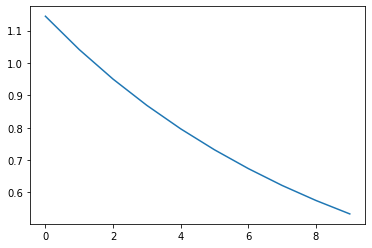

In [69]:
import matplotlib.pyplot as plt
import torch 
x = torch.ones(1, requires_grad=True) 
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)
            return output
model = Feedforward(4, 12)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
X_train = torch.tensor(X)
Y_train = torch.tensor(Y)
model.train()
epoch = 10
losses = []
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(X_train.float())
    # Compute Loss
    loss = criterion(y_pred.squeeze(), Y_train.float())
    losses.append(loss)
   #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()
plt.plot(losses)
plt.show()

### Running Chatbot

In [71]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)

> hi
Bot: hi . how are you doing ?
> I'm great. How are you?
Bot: i m okay . i m fine .
> What are you doing?
Bot: i was just looking at carla s picture .
> okay
Bot: okay okay . . . .
> where am I?
Bot: you re in the records room . ?
> where are you?
Bot: i m here . at the bend
> tell me about Deep Learning.
Checking Wikipedia...
Deep learning  (also known as deep structured learning  or hierarchical learning) is part of a broader family of machine learning methods based on artificial neural networks.
 Learning can be supervised, semi-supervised or unsupervised.
Deep learning architectures such as deep neural networks, deep belief networks, recurrent neural networks and convolutional neural networks have been applied to fields including computer vision, speech recognition, natural language processing, audio recognition, social network filtering, machine translation, bioinformatics, drug design, medical image analysis, material inspection and board game programs, where they have produc